# RNN（循环神经网络）

## 导入数据集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor()])

# 训练集
trainset = torchvision.datasets.MNIST(root='./data',     # 选择数据的根目录
                                      train=True,
                                      download=True,    # 不从网络上download图片
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True)
# 测试集
testset = torchvision.datasets.MNIST(root='./data',     # 选择数据的根目录
                                     train=False,
                                     download=True,    # 不从网络上download图片
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False)

接下来展示一个 mini-batch 的训练样本图片并标注上正确的标签。

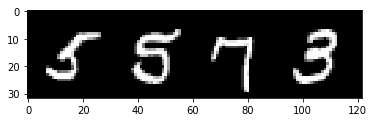

          5           5           7           3


In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 选择一个 batch 的图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
plt.show()
# 打印 labels
print(' '.join('%11s' % labels[j].numpy() for j in range(4)))

我们可以来看一下训练集和测试集的维度。

In [3]:
print(trainset.data.size())
print(testset.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## 定义 RNN 模型

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(          # 使用 LSTM 结构
            input_size = 28,         # 输入每个元素的维度，即图片每行包含 28 个像素点
            hidden_size = 84,        # 隐藏层神经元设置为 84 个
            num_layers=2,            # 隐藏层数目，单层
            batch_first=True,        # 是否将 batch 放在维度的第一位，(batch, time_step, input_size)
        )
        self.out = nn.Linear(84, 10) # 输出层，包含 10 个神经元，对应 0～9 数字

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)   
        # 选择图片的最后一行作为 RNN 输出
        out = self.out(r_out[:, -1, :])
        return out

In [5]:
net = Net()
print(net)

Net(
  (rnn): LSTM(28, 84, num_layers=2, batch_first=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


## 定义损失函数

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)                     

## 训练网络

In [ ]:
num_epoches = 5    # 设置 epoch 数目
cost = []     # 损失函数累加

for epoch in range(num_epoches):    
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 输入样本和标签
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)    # 设置 RNN 输入维度为 (batch, time_step, input_size)
        
        # 每次训练梯度清零
        optimizer.zero_grad()
        
        # 正向传播、反向传播和优化过程
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印训练情况
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每隔2000 mini-batches，打印一次
            print('[%d, %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 2000))
            cost.append(running_loss / 2000)
            running_loss = 0.0

[1,  2000] loss: 1.618
[1,  4000] loss: 0.701


In [ ]:
plt.plot(cost)
plt.ylabel('cost')
plt.show()

## 测试数据

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 28, 28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % 
     (100 * correct / total))